In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

%matplotlib inline

In [3]:
tf.config.experimental_list_devices()

['/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_CPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
faces = np.load("./face_64.npy")

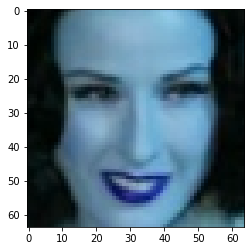

In [5]:
plt.imshow(faces[0])

In [7]:
tf.enable_eager_execution()

In [15]:
class RMSEScore(Layer):
    def __init__(self, base, **kwargs):
        self.base = tf.constant(base)
        super(RMSEScore, self).__init__(**kwargs)
    def build(self, input_shape):
        super(RMSEScore, self).build(input_shape)  
    def call(self, x):
        return K.sqrt(K.mean(K.square(tf.subtract(self.base,x)),axis=1))
    def compute_output_shape(self, input_shape):
        return [1]

In [67]:
class Net128:
    def __init__(self,base):
        base = tf.image.resize_bicubic(np.expand_dims(base,0),(128,128))
        self.inputs = Input(shape=(128,128,3))
        self.conv1 = Conv2D(16,4,activation="relu",input_shape=(128,128,3))(self.inputs)
        self.conv2 = Conv2D(16,2,activation="relu",)(self.conv1)
        self.pool1 = MaxPool2D()(self.conv2)
        self.conv3 = Conv2D(32,3,activation="relu",)(self.pool1)
        self.conv4 = Conv2D(32,3,activation="relu",)(self.conv3)
        self.pool2 = MaxPool2D()(self.conv4)
        self.flat = Flatten()(self.pool2)
        self.out = Dense(128)(self.flat)
        self.embedding_layer = Model(self.inputs,self.out)
        self.embedding_layer.load_weights("./128_by_128_emb.h5")
        self.base = self.embedding_layer.predict(base,steps=1)
        self.scoring_layer = RMSEScore(base=self.base)(self.out)
        self.model = Model(self.inputs,self.scoring_layer)   
        
    def __call__(self,inputs):
        assert inputs.ndim > 2 and inputs.ndim < 5,"Input Must Have Dimentions Greater Then 2"
        if inputs.ndim == 3:
            inputs = np.expand_dims(inputs,0)
        steps = inputs.shape[0]
        inputs = tf.image.resize_bicubic(inputs,(128,128))
        return self.model.predict(inputs,steps=steps)

In [72]:
class Net64:
    def __init__(self,base):
        base = tf.image.resize_bicubic(np.expand_dims(base,0),(64,64))
        self.inputs = Input(shape=(64,64,3))
        self.conv1 = Conv2D(16,4,activation="relu",padding="same",input_shape=(64,64,3))(self.inputs)
        self.conv2 = Conv2D(16,2,activation="relu",)(self.conv1)
        self.pool1 = MaxPool2D()(self.conv2)
        self.conv3 = Conv2D(32,3,activation="relu",)(self.pool1)
        self.conv4 = Conv2D(32,3,activation="relu",)(self.conv3)
        self.pool2 = MaxPool2D()(self.conv4)
        self.flat = Flatten()(self.pool2)
        self.out = Dense(128)(self.flat)
        self.embedding_layer = Model(self.inputs,self.out)
        self.embedding_layer.load_weights("./64_by_64_emb.h5")
        self.base = self.embedding_layer.predict(base,steps=1)
        self.scoring_layer = RMSEScore(base=self.base)(self.out)
        self.model = Model(self.inputs,self.scoring_layer)   
        
    def __call__(self,inputs):
        assert inputs.ndim > 2 and inputs.ndim < 5,"Input Must Have Dimentions Greater Then 2"
        if inputs.ndim == 3:
            inputs = np.expand_dims(inputs,0)
        steps = inputs.shape[0]
        inputs = tf.image.resize_bicubic(inputs,(64,64))
        return self.model.predict(inputs,steps=steps)

In [73]:
net = Net64(base=faces[0])

In [75]:
net(faces[0])

array([0.], dtype=float32)

In [80]:
faces[0].shape

(64, 64, 3)

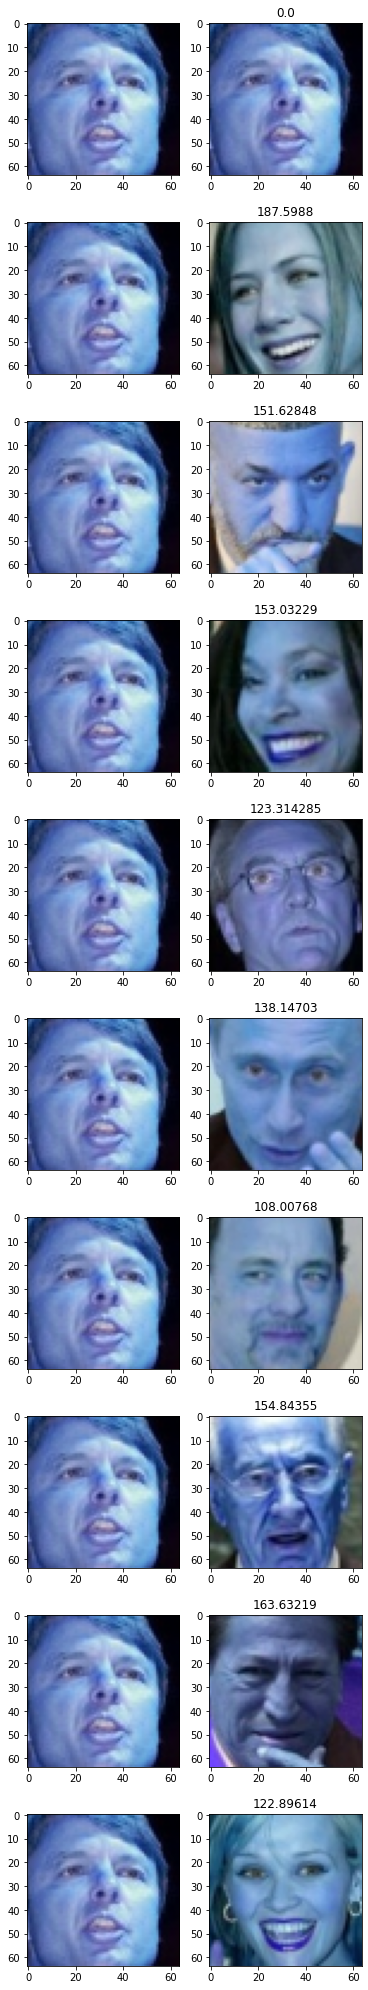

In [81]:
i = 6

fig,axes = plt.subplots(10,2,figsize=(6,36))
base_img = faces[i]

net = Net64(base=base_img)

index = np.random.randint(0,faces.shape[0],9)
axes[0,0].imshow(base_img)
axes[0,1].imshow(base_img)
axes[0,1].set_title(str(net(base_img)[0]))

for i,j in enumerate(index):
    axes[i+1,0].imshow(base_img)
    axes[i+1,1].imshow(faces[j])
    axes[i+1,1].set_title(str(net(faces[j:j+1])[0]))